In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cufflinks as cf
plt.rcParams['axes.unicode_minus'] = False

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score

from catboost import CatBoostClassifier, Pool
from mlxtend.plotting import plot_confusion_matrix

import shap
import lime
from lime import submodular_pick

/Users/wbchoi/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.



In [26]:
road_sago_final = pd.read_csv('full_data_kma_hours_lightgbm_feature_extract.csv')

In [27]:
X = road_sago_final.iloc[:, 0:-1]
y = road_sago_final.iloc[:, -1]

X_train, X_test, y_train , y_test = train_test_split(X, y, test_size = 0.2, random_state = 777)

In [28]:
y_train_create = pd.DataFrame(y_train)

In [29]:
y_train_create.columns = ['SAGO_YN']
sago_x_weight = y_train_create[y_train_create['SAGO_YN'] == 0]
sago_y_weight = y_train_create[y_train_create['SAGO_YN'] == 1]

In [30]:
len(sago_y_weight)

3001

In [31]:
weight_ratio = len(sago_x_weight) / len(sago_y_weight)
weight_ratio = round(weight_ratio, 1)
weight_ratio

4210.3

In [32]:
#Checking for any categorical features
cate_features_index = np.where(X.dtypes != float)[0]
cate_features_index

array([ 0,  1,  2,  5,  6,  7,  8,  9, 10])

In [33]:
X_train.columns

Index(['SUB_YN', 'ROAD_TYPE', 'REST_VEH', 'MAX_SPD', 'LANES', 'CW_YN',
       'BUS_YN', 'A3_ROADTYPE_1_YN', 'A1_LANE_04_YN', 'A1_BARR_03_YN',
       'A1_BARR_02_YN', 'S_P_UTERNX_CNT', 'SN_P_HDUFID_CNT', 'SF_P_ALL_CNT',
       'SF_PL_CW_CNT', 'SF_L_1_CNT', 'SUB_CNT', 'NODE_LANES_CNT',
       'NODE_INTERS_CNT', 'CW_CNT', 'BUS_CNT', 'A3_ROADTYPE_3_CNT',
       'A3_ROADTYPE_1_CNT', 'A2_STOP_2_CNT', 'A2_STOP_1_CNT', 'A1_LANE_04_CNT',
       'A1_BARR_05_CNT', 'A1_BARR_03_CNT', 'A1_BARR_02_CNT', 'topis_22_07',
       'pop_22_07', 'WS', 'WD', 'TEMP', 'RF', 'HM'],
      dtype='object')

In [34]:
#let us make the catboost model, use_best_model params will make the model prevent overfitting
# model = CatBoostClassifier(iterations=100, learning_rate=0.01, l2_leaf_reg=3.5, depth=8, rsm=0.98, loss_function= 'Logloss', 
#                            eval_metric='AUC',use_best_model=True, random_seed=42)
model = CatBoostClassifier(iterations=500, learning_rate=10e-5, l2_leaf_reg=3.5, depth=8, rsm=0.98, loss_function= 'Logloss', 
                           class_weights = [1.0 / weight_ratio, 1.0], eval_metric='AUC', random_seed=777)

In [35]:
#now just to make the model to fit the data
# model.fit(X_train, y_train, cat_features=cate_features_index, eval_set = (X_test, y_test))
model.fit(X_train, y_train, cat_features=cate_features_index)

0:	total: 6.83s	remaining: 56m 48s
1:	total: 9.97s	remaining: 41m 22s
2:	total: 16.3s	remaining: 45m
3:	total: 21.7s	remaining: 44m 55s
4:	total: 27.2s	remaining: 44m 52s
5:	total: 34.2s	remaining: 46m 54s
6:	total: 39.1s	remaining: 45m 52s
7:	total: 45.1s	remaining: 46m 16s
8:	total: 50.4s	remaining: 45m 49s
9:	total: 54.8s	remaining: 44m 47s
10:	total: 59.3s	remaining: 43m 55s
11:	total: 1m 3s	remaining: 43m 20s
12:	total: 1m 7s	remaining: 42m 7s
13:	total: 1m 11s	remaining: 41m 7s
14:	total: 1m 15s	remaining: 40m 42s
15:	total: 1m 19s	remaining: 39m 55s
16:	total: 1m 22s	remaining: 39m 11s
17:	total: 1m 27s	remaining: 38m 49s
18:	total: 1m 31s	remaining: 38m 33s
19:	total: 1m 35s	remaining: 38m 9s
20:	total: 1m 38s	remaining: 37m 30s
21:	total: 1m 41s	remaining: 36m 49s
22:	total: 1m 45s	remaining: 36m 24s
23:	total: 1m 48s	remaining: 35m 58s
24:	total: 1m 52s	remaining: 35m 28s
25:	total: 1m 55s	remaining: 34m 58s
26:	total: 1m 58s	remaining: 34m 38s
27:	total: 2m 1s	remaining: 34m

220:	total: 13m 19s	remaining: 16m 49s
221:	total: 13m 23s	remaining: 16m 45s
222:	total: 13m 26s	remaining: 16m 41s
223:	total: 13m 30s	remaining: 16m 38s
224:	total: 13m 33s	remaining: 16m 34s
225:	total: 13m 36s	remaining: 16m 30s
226:	total: 13m 40s	remaining: 16m 26s
227:	total: 13m 43s	remaining: 16m 22s
228:	total: 13m 46s	remaining: 16m 18s
229:	total: 13m 49s	remaining: 16m 13s
230:	total: 13m 52s	remaining: 16m 9s
231:	total: 13m 55s	remaining: 16m 5s
232:	total: 13m 59s	remaining: 16m 2s
233:	total: 14m 2s	remaining: 15m 57s
234:	total: 14m 6s	remaining: 15m 54s
235:	total: 14m 9s	remaining: 15m 50s
236:	total: 14m 13s	remaining: 15m 46s
237:	total: 14m 16s	remaining: 15m 43s
238:	total: 14m 21s	remaining: 15m 41s
239:	total: 14m 26s	remaining: 15m 38s
240:	total: 14m 29s	remaining: 15m 34s
241:	total: 14m 32s	remaining: 15m 29s
242:	total: 14m 35s	remaining: 15m 25s
243:	total: 14m 38s	remaining: 15m 21s
244:	total: 14m 41s	remaining: 15m 17s
245:	total: 14m 44s	remaining: 

436:	total: 26m 38s	remaining: 3m 50s
437:	total: 26m 42s	remaining: 3m 46s
438:	total: 26m 45s	remaining: 3m 43s
439:	total: 26m 48s	remaining: 3m 39s
440:	total: 26m 52s	remaining: 3m 35s
441:	total: 26m 56s	remaining: 3m 32s
442:	total: 26m 59s	remaining: 3m 28s
443:	total: 27m 3s	remaining: 3m 24s
444:	total: 27m 7s	remaining: 3m 21s
445:	total: 27m 10s	remaining: 3m 17s
446:	total: 27m 13s	remaining: 3m 13s
447:	total: 27m 16s	remaining: 3m 9s
448:	total: 27m 20s	remaining: 3m 6s
449:	total: 27m 24s	remaining: 3m 2s
450:	total: 27m 28s	remaining: 2m 59s
451:	total: 27m 32s	remaining: 2m 55s
452:	total: 27m 36s	remaining: 2m 51s
453:	total: 27m 41s	remaining: 2m 48s
454:	total: 27m 45s	remaining: 2m 44s
455:	total: 27m 48s	remaining: 2m 41s
456:	total: 27m 52s	remaining: 2m 37s
457:	total: 27m 56s	remaining: 2m 33s
458:	total: 28m	remaining: 2m 30s
459:	total: 28m 3s	remaining: 2m 26s
460:	total: 28m 7s	remaining: 2m 22s
461:	total: 28m 11s	remaining: 2m 19s
462:	total: 28m 15s	rem

In [44]:
1 + 1

2

In [36]:
y_pred = model.predict(X_test)
y_pred.shape

(3159526,)

In [37]:
# Confusion Matrix의 4가지 결과값 도출
cm = confusion_matrix(y_test, y_pred)

tn = cm[0,0]
tp = cm[1,1]
fp = cm[0,1]
fn = cm[1,0]

acc = (tp + tn) / (tp + tn + fp + fn)
prec = tp / (tp+fp)
sen = tp / (tp+fn)
spec = tn / (fp + tn)

print('정확도 (Accuracy): %f , 정밀도 (Precision): %f , 재현율 (Recall): %f , 특이도 (Specificity): %f' % (acc, prec, sen, spec))

정확도 (Accuracy): 0.762871 , 정밀도 (Precision): 0.000675 , 재현율 (Recall): 0.674667 , 특이도 (Specificity): 0.762892


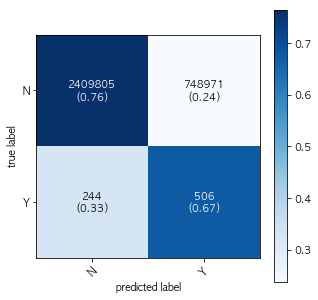

In [46]:
class_names = ['N', 'Y']
fig, ax = plot_confusion_matrix(conf_mat = cm, show_absolute=True, show_normed=True, colorbar=True, class_names = class_names)

plt.rcParams["figure.figsize"] = (5, 5)
plt.show()

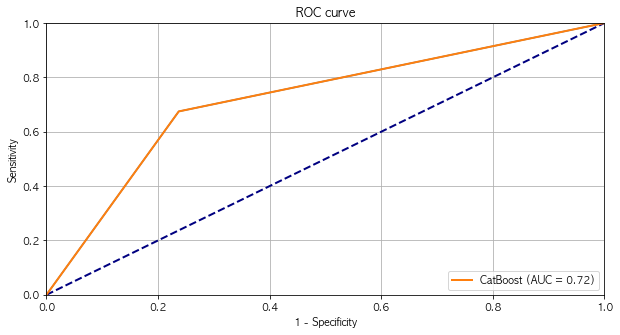

In [39]:
# ROC 커브 및 AUC 도출
FPR, TPR, thresholds = roc_curve(y_test, y_pred)

plt.figure(figsize=(10,5))  # figsize in inches
plt.plot(FPR, TPR)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # 50%
plt.plot(FPR, TPR, lw=2, label='CatBoost (AUC = %0.2f)' % auc(FPR, TPR))
plt.title('ROC curve')
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.grid(True)
plt.legend(loc="lower right")
plt.show()

In [40]:
feature_score = pd.DataFrame(list(zip(X.dtypes.index, model.get_feature_importance(Pool(X, label=y,
                cat_features=cate_features_index)))),
                columns=['Feature','Score'])

In [41]:
feature_score = feature_score.sort_values(by='Score', ascending=True, inplace=False, kind='quicksort', na_position='last')

In [42]:
feature_score = feature_score[feature_score['Score'] != 0]
feature_score

,Feature,Score
20,BUS_CNT,0.034461
21,A3_ROADTYPE_3_CNT,0.059122
30,pop_22_07,0.304576
32,WD,0.371051
35,HM,1.144379
29,topis_22_07,3.719768
33,TEMP,4.800463
7,A3_ROADTYPE_1_YN,5.606432
4,LANES,5.657825
19,CW_CNT,6.880153


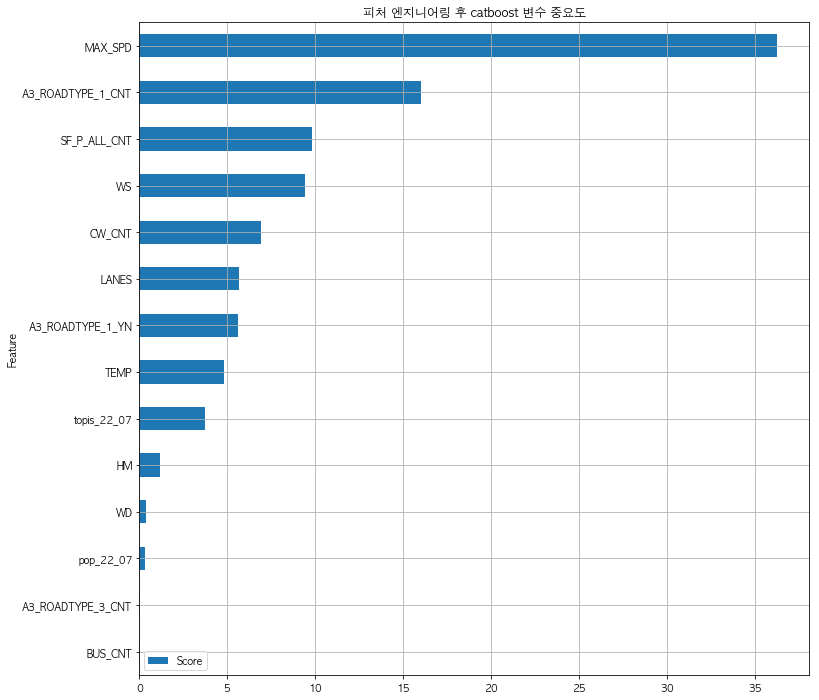

In [43]:
plt.rcParams['figure.figsize'] = (12, 12)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['font.size'] = 10
ax = feature_score.plot('Feature', 'Score', kind='barh')
plt.title('피처 엔지니어링 후 catboost 변수 중요도')
plt.grid()
plt.show()